## Analyzing service tickets with Agentic Workflows
<link rel="stylesheet"
href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css"
integrity="sha384-JcKb8q3iqJ61gNV9KGb8thSsNjpSL0n8PARn9HuZOnIxN0hoP+VmmDGMN5t9UJ0Z"
crossorigin="anonymous">
<div class="bg-info">
<h3>What are agentic workflows?</h3>
</div>

An <b>agentic workflow</b> is a multi-step sequence of tasks or decisions whose orchestration is handled by AI agents. In Generative AI, AI agents are Large Language Models (or "Large Action Models" in this context) that can perform goal-oriented tasks with minimal human intervention. Such tasks may include everything from simple reasoning tasks to complex decision making, and often involve interaction with external resources or systems (called "tools").

The following will build an agentic workflow for analyzing service tickets. The initial version of the workflow will consist of the following steps:


1.   An **analyzer** agent which will analyze the service tickets and provide comprehensive guidance for handling the service tickets.
2.   A **searcher** agent (LLM + search tool) which will search the web for supporting links based on the guidance provided by the analyzer.
3.   A **judge** agent which will classify the level of severity of the service ticket based on feedback from the analyzer.



<div class="bg-info">
<h3>What is the difference between an agentic framework and an agentic orchestration framework?</h3>
</div>

There are different schools of thought about agentic orchestration frameworks.

Agentic orchestration can refer to <b>agent-of-agent</b> systems, which are defined based on the number of agents. In this case, they are simply agentic systems that consist of more than a single agent. Hence, it can refer to agentic systems with multiple agents; it can also refer to agentic systems that invoke other agentic systems.

Sometimes, agentic orchestration can also be used to distinguish complex multi-agent systems from simpler agentic systems. In this case, agentic orchestration is only necessary for systems with high levels of complexity. This is based on not just the number of agents, but other factors such as the types of flows (directed versus cyclic).

There are many frameworks that can be used for building agentic workflows. Due to their reasoning and decision-making abilities, LLMs are a natural fit for driving autonomous workflows. However, users often want the ability to extend, constrain or even override aspects of the flow. For example, they may need a way to dynamically limit cycles, manage state across disparate tools, or integrate human-in-the-loop fedback. A popular approach is to use <b>LLM orchestration</b> frameworks. These are frameworks that combine the flexible and dynamic capabilities of agent-driven workflows with low-level control over essential details of the orchestration. This notebook uses <b>LangChain</b> to build the AI agents, and <b>LangGraph</b> to build the agentic workflow that orchestrates the agents.

<div class="bg-info">
<h3>Workflow Summary</h3>
</div>

Steps of the Log Analyzer:
- <i>Analyzer</i> agent receives the sevice ticket to be interpreted and generates a comprehensive analysis of the ticket.
  - The workflow sends the analysis to the Searcher agent.
- <i>Searcher</i> agent receives the article writing request from the user and executes a web search request. It is a tool-based agent, so it uses a tool for its search (indicated by tools in the diagram. The tool it uses is called Tavily - Tavily is a search engine agentic tool.)
  - If it receives a tool invocation request, the workflow sends the request to the Tool Node (Tavily)
  - Else, the workflow sends the search results back to the Analyzer agent.
- <i>Analyzer</i> agent receives the results from the Searcher agent and determines whether or not they should be flagged for critical issues.
  - If critical issues need to be addressed, the analyzer handles the ticket as critical (in this case, it simply outputs a warning).
  - Else, the workflow sends the analyzer's feedback to the Judge agent.
- <i>Judge</i> agent receives the feedback from the Analyzer agent and determines the level of serverity of the ticket.
  - The judge classifies the ticket as HIGH, MEDIUM or LOW risk.
  - The workflow ends.

# Setup

In [277]:
# Import libraries
from typing import TypedDict, Literal
import json
import random
from langgraph.graph import END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from langchain_core.messages import HumanMessage
import os
from typing import Annotated, Literal, TypedDict
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
import functools
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain.text_splitter import RecursiveCharacterTextSplitter
import time
from ipywidgets import FileUpload, Button, Output
from IPython.display import display
import codecs

## Defining Templates
Each agent has its own specific **template**. The templates are defined here.

In [278]:
analyst_template = """
Your job is to act as an intelligent system analyst. Please provide a comprehensive analysis of the service ticket provided in the request. Include a brief summary about whether this service ticket should be treated as a critical issue by the operations team

Start with this line: FROM ANALYST

NOTE: Do not write the analysis until you receive links from the searcher node.
If you have not yet received links from the searcher node, forward your analysis to the searcher node.
Otherwise, only if you did receive links from the searcher node and re-write the analysis with the links from the searcher node, and say ### NEXT.
"""

searcher_template = """
Your job is to search the web for links that would be relevant for generating the analysis described by the analyst node.

NOTE: Do not write the analysis. Just search the web for related links if needed, and forward it to the analyst node.

Use this format:
### FROM SEARCHER:
<search results>
"""

judge_template = """
Your job is to receive the log analysis from the analyst node and provide your classification of the severity as HIGH, MODERATE or LOW.
Use your best judgement as a system operator to determine the level of severity of the service ticket analysis. Do not provide any additional explanation for your classification.

Use this format:

### FROM JUDGE:
### Level of severity: 
# <classification>


When finished, say #### DONE
"""

## Defining State
Here, we will define our **GraphState**, as well as the **nodes** and **edges** that our graph is comprised of. This will encapsulate **state** in our agentic workflows.

In [279]:
#####################################
## STATE ##
#####################################
class NMAgentState(TypedDict):
  """
  Encapsulates state in our agentic workflow
  """
  messages: Annotated[list, add_messages]

#####################################
## TOOLS ##
#####################################
google_search_tool = TavilySearchResults(max_results=5, include_answer=True, include_raw_content=True, include_images=True,)

#####################################
## AGENTS ##
#####################################
"""
The LLMs used by the agents
"""
granite_llm = ChatOpenAI(temperature=0,
                         model="granite-3-3-8b-instruct",
                         request_timeout=240)

def create_agent(llm, tools, system_message: str):
    """
    Creates an agent with the given LLM, tools, and system message
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm

searcher_agent = create_agent(granite_llm, [google_search_tool], searcher_template)
analyst_agent = create_agent(granite_llm, [], analyst_template)
judge_agent = create_agent(granite_llm, [], judge_template)

#####################################
## NODES ##
#####################################
def agent_node(state, agent, name):
  result = agent.invoke(state)
  return { "messages": [result] }

searcher_node = functools.partial(agent_node, agent=searcher_agent, name="Search Agent")
analyst_node = functools.partial(agent_node, agent=analyst_agent, name="Analyst Agent")
judge_node = functools.partial(agent_node, agent=judge_agent, name="Judge Agent")
tool_node = ToolNode([google_search_tool])

#####################################
## EDGES ##
#####################################
def should_search(state) -> Literal['tools', 'analyst']:
  if len(state['messages']) and state['messages'][-1].tool_calls:
    return "tools"
  else:
    return "analyst"

def should_submit(state) -> Literal['searcher', "judge"]:
  if len(state['messages']) and '### NEXT' in state['messages'][-1].content:
    return "judge"
  else:
    return "searcher"

## Defining the Workflow Graph
Here, we will define the workflow, which will encapsulate the state, nodes and edges defined above.

In [280]:
workflow = StateGraph(NMAgentState)

# nodes
workflow.add_node("searcher", searcher_node)
workflow.add_node("analyst", analyst_node)
workflow.add_node("tools", tool_node)
workflow.add_node("judge", judge_node)

# entrypoint
workflow.set_entry_point("analyst")

# edges
workflow.add_conditional_edges("searcher", should_search)
workflow.add_conditional_edges("analyst", should_submit)
workflow.add_edge("tools", "searcher")
workflow.add_edge("judge", END)

# compile the workflow into a graph
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

Visualize the graph:

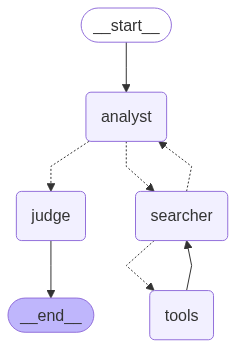

In [281]:
Image(graph.get_graph().draw_mermaid_png())

# Testing the workflow
Now that the workflow has been generated, we can test it out with different files.

In [282]:
# Display a file upload widget
upload_widget = FileUpload(
    accept='', 
    multiple=False,
)

upload_output = Output()

display(upload_widget)

upload_response=input("Select a file, then enter any key to continue:")

display(upload_output) 

# Test the workflow with prompts
@upload_output.capture()
def on_upload_change(change):
    file_content= f"""{upload_widget.value[0].content.tobytes().decode("utf-8")}"""
    input_text = f"""Provide an analysis for the following service ticket:\n\n{file_content}"""
    config = {"configurable": {"thread_id": 12, "recursion_limit": 10}}
    try:
      for event in graph.stream({"messages": [HumanMessage(content=input_text)]}, config, stream_mode="values"):
          event['messages'][-1].pretty_print()
    except Exception as e:
      print(f"\n\nErrors generating response:\n===============\n {str(e)}")

upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), description='Upload')

Select a file, then enter any key to continue: y


Output()